1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [41]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

There are 8 local minima
Local Minimum: [-1.70361  0.79608]; Value: -0.215
Local Minimum: [-1.60711 -0.56865]; Value: 2.104
Local Minimum: [-1.6071  -0.56865]; Value: 2.104
Local Minimum: [-0.08984  0.71266]; Value: -1.032
Local Minimum: [ 0.08984 -0.71266]; Value: -1.032
Local Minimum: [1.6071  0.56865]; Value: 2.104
Local Minimum: [1.60711 0.56865]; Value: 2.104
Local Minimum: [ 1.70361 -0.79608]; Value: -0.215
Global Minimum:  -1.03163


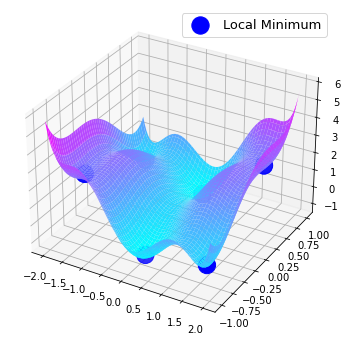

In [42]:
def f (param):
    x,y = param
    return (4. - 2.1*x**2 + (x**4)/3)*(x**2) + x*y + (4*y**2 -4)*(y**2)

X = np.linspace(-2, 2, 100)
Y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection = "3d")

surf = ax.plot_surface(X,Y,f([X,Y]), cmap="cool")

X =np.linspace(-2,2,20)
Y =np.linspace(-1,1,20)

local_minimas = []
values_minima = []
for x in X:
    for y in Y:
        minima = optimize.minimize(f, [x,y]).x
        local_minimas.append(np.around(minima, decimals=5))
        values_minima.append(np.around(f(minima), decimals=5))
        
local_minimas, idx = np.unique(np.array(local_minimas), axis=0, return_index=True)
values_minima = np.array(values_minima)[idx]

print ("There are {} local minima".format(len(local_minimas)))

for xy, value in zip(local_minimas, values_minima):
    print("Local Minimum: {}; Value: {:.3f}".format(xy,value))

ax.scatter3D(local_minimas[:,0], local_minimas[:,1], values_minima, s=300, c="b", label="Local Minimum")
plt.legend(fontsize=13)
print("Global Minimum: ", min(values_minima))



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0.5, 1.0, 'Minimum/Maximum Temperature of Alaska throughout a year')

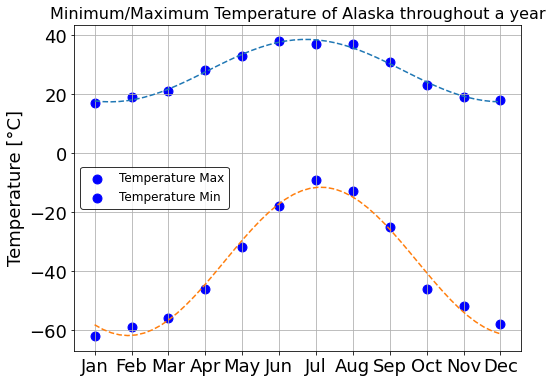

In [43]:
from scipy.interpolate import interp1d

max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(1,13,1)
months_label = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#now we plot
fig = plt.figure(figsize=(8,6))
plt.scatter(months,max_temp,c="b", s=80, label="Temperature Max")
plt.scatter(months,min_temp,c="b", s=80, label="Temperature Min")
plt.grid(True)

plt.ylabel("Temperature [°C]", fontsize=18)
plt.xticks(ticks=months, labels=months_label, fontsize=18)
plt.yticks(fontsize=18)
legend = plt.legend(fontsize=12, frameon = 0.5)

frame = legend.get_frame()
frame.set_edgecolor("black")

#fitting
def f_guess(x, A, B, Phi, C):
    return A*np.sin(B*x + Phi) + C

#fitting the maximum temperatur
init_param = [50,1,1,20]
popt_max, pcov_max = optimize.curve_fit(f_guess,months, max_temp, p0=init_param)
times = np.linspace(1,12,50)
plt.plot(times, f_guess(times, popt_max[0], popt_max[1],popt_max[2],popt_max[3] ), linestyle="dashed")

#fitting the maximum temperatur
init_param = [-30,1,1,-20]
popt_min, pcov_min = optimize.curve_fit(f_guess,months, min_temp, p0=init_param)
times = np.linspace(1,12,50)
plt.plot(times, f_guess(times, popt_min[0], popt_min[1],popt_min[2],popt_min[3] ), linestyle="dashed")

plt.title("Minimum/Maximum Temperature of Alaska throughout a year", fontsize =16)

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

P_Value = 0.781329280320036
Chi2 = 0.49351720854101166


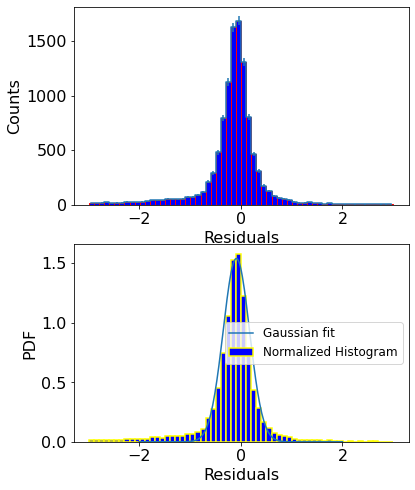

In [44]:
import matplotlib
import pandas as pd
from scipy import stats
from scipy.stats import norm

#read dataframe and filter

df = pd.DataFrame(pd.read_pickle("./data/residuals_261.pkl").item())
df = df[df["residuals"]>-3]
df = df[df["residuals"]<3]

nbins = 60

#plot1 
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6,8))

hist1 = ax[0].hist((df["residuals"]), bins=nbins, color="blue", edgecolor="red")
y= hist1[0]
bin_edges = hist1[1]
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

ax[0].errorbar(bin_centers, y, yerr = y**0.5, drawstyle = "steps-mid")

#now adjust ax0
ax[0].tick_params(axis="x", labelsize=16)
ax[0].tick_params(axis="y", labelsize=16)
ax[0].set_xlabel("Residuals", fontsize=16)
ax[0].set_ylabel("Counts", fontsize=16)

#fitting
def f_gauss(x, mean, std):
    return norm.pdf(x, mean, std)



#fit
def f_gauss(x, mean, std):
    return norm.pdf(x, mean, std)

hist2 = ax[1].hist((df["residuals"]), bins = nbins, color = "blue", edgecolor ="yellow", label = "Normalized Histogram", density = True, linewidth = 1.5)
y = hist2[0]

popt, pcov = optimize.curve_fit(f_gauss, bin_centers, y, p0=[0,0.5])

#second plot

x = np.linspace(-2,2,200)
y_fit = norm.pdf(x, popt[0], popt[1])
ax[1].plot(x, y_fit, label="Gaussian fit")

#adjusting ax1
ax[1].tick_params(axis="x", labelsize=16)
ax[1].tick_params(axis="y", labelsize=16)
ax[1].set_xlabel("Residuals", fontsize=16)
ax[1].set_ylabel("PDF", fontsize=16)
ax[1].legend(fontsize = 12)

chi2 = np.sum((y-norm.pdf(bin_centers,popt[0], popt[1]))**2/y**0.5)
pvalue= 1. - stats.chi2.cdf(chi2, 2)
print ("P_Value =", pvalue)
print ("Chi2 =", chi2)



4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

Best Fit Values
a= -9.988
b=  12.333
c=  9.384
Average for Overall Temperature between 2008 and 2012= 9.384
Coolest Daily Average Temperature of the Year =  -0.6
Warmest Daily Average Temperature of the Year =  19.37


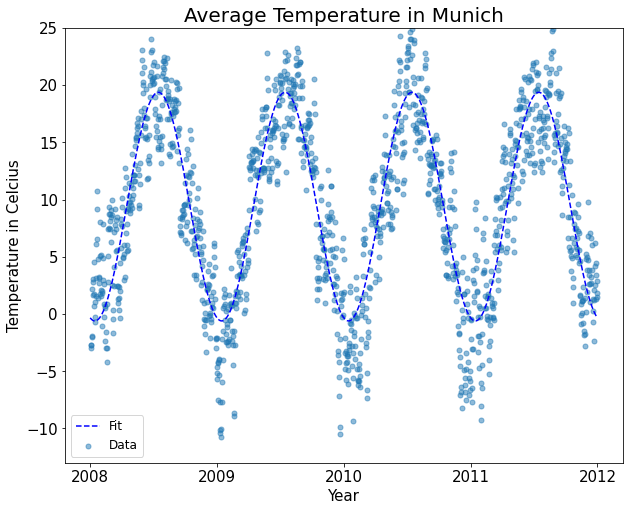

In [45]:
#1. Making data plot and best fit model 2008-2012
import pandas as pd
def f(t, a, b, c):
    return a*np.cos(2*np.pi*t + b) +c
munich_temp = pd.read_csv("./data/munich_temperatures_average_with_bad_data.txt", sep= " ", names = ["time", "avg_temp"])

#filter the data
munich_temp = munich_temp[munich_temp["time"] >2008]
munich_temp = munich_temp[munich_temp["time"] <2012]

#fi1
initial_guess = [1.,1.,1.]
popt, pcov = optimize.curve_fit(f, munich_temp.time,munich_temp.avg_temp)
munich_temp["fit1_pred"]= munich_temp["time"].apply(lambda x: f(x, popt[0], popt[1], popt[2])) #save prediction1


#plotting fit 1 vs data
x=np.linspace(2008,2012,2000)
y_fit = f(x, popt[0], popt[1], popt[2])
fig =plt.figure(figsize=(10,8))
plt.plot(x,y_fit, color="blue", linewidth=1.5, linestyle="dashed", label="Fit")

plt.scatter(munich_temp.time, munich_temp.avg_temp, marker=".", s=100, alpha=0.5, label="Data")

#now we adjust the plot
plt.ylim(-13,25)
plt.yticks(fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.xticks(ticks=np.arange(2008,2013,1), fontsize = 15)
plt.ylabel("Temperature in Celcius", fontsize = 15)
plt.legend(fontsize = 12)
plt.title("Average Temperature in Munich", fontsize = 20)

print ("Best Fit Values")
print ("a= {: .3f}".format(popt[0]))
print ("b= {: .3f}".format(popt[1]))
print ("c= {: .3f}".format(popt[2]))
print ("Average for Overall Temperature between 2008 and 2012= {:.3f}".format(munich_temp["avg_temp"].mean()))
print ("Coolest Daily Average Temperature of the Year = ", min(np.around(y_fit, decimals=2)))
print ("Warmest Daily Average Temperature of the Year = ", max(np.around(y_fit, decimals=2)))

#fit2
def g(t,a,b,c,d):
    return a*np.cos(2*b*np.pi*t + c) + d

initial_guess = [1.,1.,1.,1.]
popt, pcov = optimize.curve_fit(g, munich_temp.time,munich_temp.avg_temp)
munich_temp["fit2_pred"]= munich_temp["time"].apply(lambda x: g(x, popt[0], popt[1], popt[2], popt[3])) #save prediction2



In [46]:
#2.fitting the data with g(x) function
import pandas as pd
from scipy import stats

#add RSS for both fits to dataframe
munich_temp["RSS_fit1"] = (munich_temp.avg_temp - munich_temp.fit1_pred)**2
munich_temp["RSS_fit2"] = (munich_temp.avg_temp - munich_temp.fit2_pred)**2

def Ftest(rss1,rss2,ndof_1,ndof_2,nbins, verbose=False):
    F = ((rss1-rss2)/(ndof_2-ndof_1))/(rss2/(nbins-ndof_2))
    CL = 1. - stats.f.cdf(F,ndof_2-ndof_1, nbins-ndof_2)
    if verbose: print("CL= %.3f" % CL, ", additional parameter necessary =", "YES" if CL < 0.10 else "NO")
    return CL

rss1 = munich_temp["RSS_fit1"].sum()
rss2 = munich_temp["RSS_fit2"].sum()
print("RSS= ", rss1, rss2)
Ftest (rss1, rss2, 2, 3, munich_temp.shape[0], verbose=True)


RSS=  34359.85859996652 34352.794053704085
CL= 0.584 , additional parameter necessary = NO


0.5840708127716518

In [47]:
munich_temp

,time,avg_temp,fit1_pred,fit2_pred,RSS_fit1,RSS_fit2
4748,2008.00274,-2.94444,-0.371638,-0.310373,6.619309,6.938309
4749,2008.00548,-2.66667,-0.407067,-0.348952,5.105806,5.371819
4750,2008.00821,-2.66667,-0.439480,-0.384508,4.960374,5.208264
4751,2008.01095,-2.00000,-0.469106,-0.417292,2.343636,2.504964
4752,2008.01369,-1.94444,-0.495812,-0.447159,2.098524,2.241851
...,...,...,...,...,...,...
6204,2011.98836,3.44444,-0.138575,-0.170386,12.837995,13.066967
6205,2011.99110,1.27778,-0.189041,-0.217992,2.151565,2.237334
6206,2011.99384,2.88889,-0.236671,-0.262740,9.769129,9.932771
6207,2011.99658,1.83333,-0.281448,-0.304616,4.472287,4.570813
